# Baseball: Can we predict which team will win a game?
- Variables:
 - From previous year:
    - Starting pitcher stats.
    - Lineup stats.

## To Do:
- ~Numbers from prior year for each player and pitcher.~
- Engineer descriptive columns.
    - ~Team batting stats.~
    - ~Pitching stats.~
    - ~Pitching / hitting interactions.~


# Collecting Data
***This analysis will try to predict the outcome of games from `year=2016` using stats from `year=2015`.***

- Retrosheet: https://www.retrosheet.org/
    - Game Logs: https://www.retrosheet.org/gamelogs/index.html
    - Header columns: https://raw.githubusercontent.com/maxtoki/baseball_R/master/data/game_log_header.csv
    - ~Event Files: https://www.retrosheet.org/eventfile.htm~

> **The information used here was obtained free of
charge from and is copyrighted by Retrosheet.  
> Interested
parties may contact Retrosheet at "www.retrosheet.org".**

**Kaggle Data:**
- Batting: https://www.kaggle.com/seanlahman/the-history-of-baseball?select=batting.csv
- Pitching: https://www.kaggle.com/seanlahman/the-history-of-baseball?select=pitching.csv
- Players: https://www.kaggle.com/seanlahman/the-history-of-baseball?select=player.csv

In [1]:
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])

import pandas as pd
pd.set_option('display.max_columns', None)

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
headers = pd.read_csv('gl2019/game_log_header.txt')
games_2016 = pd.read_csv('gl2016/GL2016.TXT', header=None)
games_2016.columns = headers.columns
games_2016.head()

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,HomeRunsScore,LengthInOuts,DayNight,CompletionInfo,ForfeitInfo,ProtestInfo,ParkID,Attendence,Duration,VisitorLineScore,HomeLineScore,VisitorAB,VisitorH,VisitorD,VisitorT,VisitorHR,VisitorRBI,VisitorSH,VisitorSF,VisitorHBP,VisitorBB,VisitorIBB,VisitorK,VisitorSB,VisitorCS,VisitorGDP,VisitorCI,VisitorLOB,VisitorPitchers,VisitorER,VisitorTER,VisitorWP,VisitorBalks,VisitorPO,VisitorA,VisitorE,VisitorPassed,VisitorDB,VisitorTP,HomeAB,HomeH,HomeD,HomeT,HomeHR,HomeRBI,HomeSH,HomeSF,HomeHBP,HomeBB,HomeIBB,HomeK,HomeSB,HomeCS,HomeGDP,HomeCI,HomeLOB,HomePitchers,HomeER,HomeTER,HomeWP,HomeBalks,HomePO,HomeA,HomeE,HomePassed,HomeDB,HomeTP,UmpireHID,UmpireHName,Umpire1BID,Umpire1BName,Umpire2BID,Umpire2BName,Umpire3BID,Umpire3BName,UmpireLFID,UmpireLFName,UmpireRFID,UmpireRFName,VisitorManagerID,VisitorManagerName,HomeManagerID,HomeManagerName,WinningPitcherID,WinningPitcherName,LosingPitcherID,LosingPitcherNAme,SavingPitcherID,SavingPitcherName,GameWinningRBIID,GameWinningRBIName,VisitorStartingPitcherID,VisitorStartingPitcherName,HomeStartingPitcherID,HomeStartingPitcherName,VisitorBatting1PlayerID,VisitorBatting1Name,VisitorBatting1Position,VisitorBatting2PlayerID,VisitorBatting2Name,VisitorBatting2Position,VisitorBatting3PlayerID,VisitorBatting3Name,VisitorBatting3Position,VisitorBatting4PlayerID,VisitorBatting4Name,VisitorBatting4Position,VisitorBatting5PlayerID,VisitorBatting5Name,VisitorBatting5Position,VisitorBatting6PlayerID,VisitorBatting6Name,VisitorBatting6Position,VisitorBatting7PlayerID,VisitorBatting7Name,VisitorBatting7Position,VisitorBatting8PlayerID,VisitorBatting8Name,VisitorBatting8Position,VisitorBatting9PlayerID,VisitorBatting9Name,VisitorBatting9Position,HomeBatting1PlayerID,HomeBatting1Name,HomeBatting1Position,HomeBatting2PlayerID,HomeBatting2Name,HomeBatting2Position,HomeBatting3PlayerID,HomeBatting3Name,HomeBatting3Position,HomeBatting4PlayerID,HomeBatting4Name,HomeBatting4Position,HomeBatting5PlayerID,HomeBatting5Name,HomeBatting5Position,HomeBatting6PlayerID,HomeBatting6Name,HomeBatting6Position,HomeBatting7PlayerID,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20160403,0,Sun,NYN,NL,1,KCA,AL,1,3,4,51,N,NaN,NaN,NaN,KAN06,40030,193,000000030,10010200x,33,7,1,0,0,3,0,0,0,6,0,9,0,1,0,0,9,3,3,3,0,0,24,15,1,1,3,0,30,9,0,0,0,4,0,1,0,2,0,3,1,0,3,0,5,5,3,3,0,0,27,13,0,0,0,0,davig901,Gerry Davis,holbs901,Sam Holbrook,drakr901,Rob Drake,torrc901,Carlos Torres,NaN,(none),NaN,(none),collt801,Terry Collins,yoste001,Ned Yost,volqe001,Edinson Volquez,harvm001,Matt Harvey,daviw001,Wade Davis,hosme001,Eric Hosmer,harvm001,Matt Harvey,volqe001,Edinson Volquez,granc001,Curtis Granderson,9,wrigd002,David Wright,5,cespy001,Yoenis Cespedes,7,dudal001,Lucas Duda,3,walkn001,Neil Walker,4,confm001,Michael Conforto,10,cabra002,Asdrubal Cabrera,6,darnt001,Travis d'Arnaud,2,lagaj001,Juan Lagares,8,escoa003,Alcides Escobar,6,mousm001,Mike Moustakas,5,cainl001,Lorenzo Cain,8,hosme001,Eric Hosmer,3,morak001,Kendrys Morales,10,gorda001,Alex Gordon,7,peres002,Salvador Perez,2,infao001,Omar Infante,4,fuenr001,Reymond Fuentes,9,NaN,Y
1,20160403,0,Sun,TOR,AL,1,TBA,AL,1,5,3,54,D,NaN,NaN,NaN,STP01,31042,171,200100020,001000002,35,7,1,0,1,5,0,0,0,3,0,16,0,0,0,0,6,2,3,3,1,0,27,15,2,0,0,0,35,7,1,0,1,3,0,0,0,1,0,7,0,1,0,0,6,4,4,4,1,0,27,8,1,0,0,0,everm901,Mike Everitt,emmep901,Paul Emmel,timmt901,Tim Timmons,diazl901,Laz Diaz,NaN,(none),NaN,(none),gibbj001,John Gibbons,cashk001,Kevin Cash,strom001,Marcus Stroman,archc001,Chris Archer,osunr001,Roberto Osuna,encae001,Edwin Encarnacion,strom001,Marcus Stroman,archc001,Chris Archer,pillk001,Kevin Pillar,8,donaj001,Josh Donaldson,5,bautj002,Jose Bautista,9,encae001,Edwin Encarnacion,10,tulot001,Troy Tulowitzki,6,colac001,Chri

# Scrape columns from game data.

In [3]:
new_col_names = ['visitor_starter', 'home_starter',
                 'visitor_lineup', 'home_lineup',
                 'home_team_won']
new_rows = []

for idx, game in games_2016.iterrows():
    visitor_starter = game['VisitorStartingPitcherID']
    home_starter = game['HomeStartingPitcherID']
    
    visitor_lineup = [game[v] for v in 
                      [f'VisitorBatting{i}PlayerID' for i in range(1, 9+1)]]
    home_lineup = [game[v] for v in 
                      [f'HomeBatting{i}PlayerID' for i in range(1, 9+1)]]
    
    home_team_won = (game['VisitorRunsScored'] - game['HomeRunsScore']) < 0
    
    new_rows.append([visitor_starter, home_starter, 
                     visitor_lineup, home_lineup, 
                     home_team_won])
    
scraped_cols = pd.DataFrame(new_rows, columns=new_col_names)
scraped_cols.head()

,visitor_starter,home_starter,visitor_lineup,home_lineup,home_team_won
0,harvm001,volqe001,"[granc001, wrigd002, cespy001, dudal001, walkn...","[escoa003, mousm001, cainl001, hosme001, morak...",True
1,strom001,archc001,"[pillk001, donaj001, bautj002, encae001, tulot...","[forsl001, morrl001, longe001, dickc002, jennd...",False
2,waina001,lirif001,"[carpm002, phamt001, hollm001, gricr001, piscs...","[jasoj001, mccua001, freed001, marts002, cervf...",True
3,arrij001,richg002,"[fowld001, heywj001, zobrb001, rizza001, bryak...","[escoy001, navad002, troum001, pujoa001, calhk...",False
4,sante001,tillc001,"[dozib001, mauej001, sanom001, plout001, rosae...","[machm001, jonea003, davic003, trumm001, wietm...",True


# Load in player data from Kaggle.

- Hitters:
 - At-bats
 - Hits
 - Total Bases
 - Walks + HBP
- Pitchers
 - Outs recorded
 - Hits allowed
 - Walks allowed

In [4]:
players = pd.read_csv('player.csv')
players = players[['player_id', 'retro_id']].set_index('player_id')
players.head()

,retro_id
player_id,
aardsda01,aardd001
aaronha01,aaroh101
aaronto01,aarot101
aasedo01,aased001
abadan01,abada001


In [5]:
batting = pd.read_csv('batting.csv')
batting.head()

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,triple,hr,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,g_idp
0,abercda01,1871,1,TRO,NaN,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,25,118.0,30.0,32.0,6.0,0.0,0.0,13.0,8.0,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137.0,28.0,40.0,4.0,5.0,0.0,19.0,3.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133.0,28.0,44.0,10.0,2.0,2.0,27.0,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120.0,29.0,39.0,11.0,3.0,0.0,16.0,6.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [6]:
batting_2015 = batting[batting['year'] == 2015]
batting_2015 = batting_2015.groupby('player_id').sum().reset_index()
batting_2015 = batting_2015[['player_id', 'ab', 'h', 
                             'double', 'triple', 'hr', 
                             'bb', 'hbp']]
batting_2015.shape

(1348, 8)

In [7]:
batting_2015 = pd.merge(players, batting_2015, 
                        left_index=True, right_on='player_id')
display(batting_2015.head())
batting_2015.shape

,retro_id,player_id,ab,h,double,triple,hr,bb,hbp
0,aardd001,aardsda01,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abadf001,abadfe01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abrej003,abreujo02,613.0,178.0,34.0,3.0,30.0,39.0,15.0
3,achta001,achteaj01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ackld001,ackledu01,238.0,55.0,11.0,3.0,10.0,18.0,1.0


(1348, 9)

In [8]:
pitching = pd.read_csv('pitching.csv')
pitching.head()

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,sho,sv,ipouts,h,er,hr,bb,so,baopp,era,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78.0,43,23,0,11,1,NaN,7.96,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792.0,361,132,4,37,13,NaN,4.50,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3.0,8,3,0,0,0,NaN,27.00,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639.0,295,103,3,31,15,NaN,4.35,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27.0,20,10,0,3,0,NaN,10.00,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [9]:
pitching_2015 = pitching[pitching['year'] == 2015]
pitching_2015 = pitching_2015.groupby('player_id').sum().reset_index()
pitching_2015 = pitching_2015[['player_id', 'ipouts', 'h', 'bb', 'so']]
pitching_2015.shape

(735, 5)

In [10]:
pitching_2015 = pd.merge(players, pitching_2015, 
                         left_index=True, right_on='player_id')
display(pitching_2015.head())
pitching_2015.shape

,retro_id,player_id,ipouts,h,bb,so
0,aardd001,aardsda01,92.0,25,14,35
1,abadf001,abadfe01,143.0,45,19,45
2,achta001,achteaj01,40.0,12,6,14
3,adama001,adamsau01,100.0,37,13,23
4,adcon001,adcocna01,54.0,15,12,13


(735, 6)

# Compile columns:
- `visitor_starter` stats.
- `home_starter` stats.
- `visitor_lineup` stats.
- `home_lineup` stats.

In [11]:
def match_retro_id(stats_df, game_data, col, to_drop, 
                   pitcher=False, lineup=False):
    """
    Matches `retro_id` from `col` in `game_data` 
    with their stats from `stats_df`.
    
    Returns a list of stats (predetermined)
    """
    current_row = []
    if pitcher:
        player_stats = pitching_2015[pitching_2015['retro_id'] == game[col]]
        if len(player_stats) == 1:
            current_row += list(player_stats.drop(to_drop, axis=1).values[0])
        else:
            current_row += [0, 0, 0, 0]
    if lineup:
        lu_stats = stats_df[
            stats_df['retro_id'].isin(game_data[col])]
        current_row += list(lu_stats.drop(to_drop, axis=1).sum().values)
    return current_row

In [12]:
to_drop = ['retro_id', 'player_id']

new_col_names = [
    'visitor_starter_ipouts', 'visitor_starter_h', 
    'visitor_starter_bb', 'visitor_starter_so',
    'home_starter_ipouts', 'home_starter_h', 
    'home_starter_bb', 'home_starter_so',
    'visitor_ab', 'visitor_h', 'visitor_double', 
    'visitor_triple', 'visitor_hr', 'visitor_bb', 'visitor_hbp',
    'home_ab', 'home_h', 'home_double', 
    'home_triple', 'home_hr', 'home_bb', 'home_hbp',
    'home_team_won'
]
new_rows = []

for idx, game in scraped_cols.iterrows():
    current_row = []

    # visitor_starter
    current_row += match_retro_id(pitching_2015, game, 
                                  'visitor_starter', to_drop, pitcher=True)

    # home_starter
    current_row += match_retro_id(pitching_2015, game, 
                                  'home_starter', to_drop, pitcher=True)

    # visitor_lineup
    current_row += match_retro_id(batting_2015, game, 
                                  'visitor_lineup', to_drop, lineup=True)

    # home_lineup
    current_row += match_retro_id(batting_2015, game, 
                                  'home_lineup', to_drop, lineup=True)
    
    # home_team_won
    current_row += [game['home_team_won']]
    
    new_rows.append(current_row)
    
games_engineered = pd.DataFrame(new_rows, columns=new_col_names)
games_engineered['home_team_won'] = games_engineered['home_team_won'].map({
    True: 1, False: 0
})

In [13]:
# Reordering columns.
games_engineered = games_engineered[['home_team_won'] + \
                                    list(games_engineered.drop('home_team_won', 
                                                               axis=1).columns)]
games_engineered.head()

,home_team_won,visitor_starter_ipouts,visitor_starter_h,visitor_starter_bb,visitor_starter_so,home_starter_ipouts,home_starter_h,home_starter_bb,home_starter_so,visitor_ab,visitor_h,visitor_double,visitor_triple,visitor_hr,visitor_bb,visitor_hbp,home_ab,home_h,home_double,home_triple,home_hr,home_bb,home_hbp
0,1,568.0,156.0,37.0,188.0,601.0,190.0,72.0,155.0,3738.0,998.0,219.0,22.0,151.0,348.0,46.0,4205.0,1156.0,228.0,26.0,117.0,296.0,62.0
1,0,81.0,20.0,6.0,18.0,636.0,175.0,66.0,252.0,3944.0,1078.0,217.0,14.0,192.0,445.0,43.0,3439.0,888.0,176.0,26.0,114.0,311.0,36.0
2,1,84.0,25.0,4.0,20.0,560.0,155.0,70.0,205.0,2988.0,803.0,171.0,26.0,92.0,276.0,37.0,3675.0,1005.0,214.0,17.0,85.0,331.0,62.0
3,0,687.0,150.0,48.0,236.0,622.0,181.0,76.0,176.0,4175.0,1109.0,231.0,26.0,154.0,516.0,61.0,4107.0,1104.0,184.0,17.0,145.0,359.0,47.0
4,1,324.0,104.0,36.0,82.0,519.0,176.0,64.0,120.0,3496.0,879.0,198.0,31.0,110.0,309.0,23.0,3671.0,961.0,172.0,8.0,189.0,312.0,26.0


# Engineer columns:

## Pitching:
- WHIP
    - *Walks plus hits per inning pitched.*
        - $WHIP = {\frac  {BB + H}{IP}}$
- SO Rate
    - `Strikeouts` per `ipout`.
        - $sorate = {\frac  {so}{IP}}$

In [14]:
# Visitor
v_h = games_engineered['visitor_starter_h']
v_bb = games_engineered['visitor_starter_bb']
v_so = games_engineered['visitor_starter_so']
v_ip = games_engineered['visitor_starter_ipouts'] / 3

games_engineered['visitor_starter_whip'] = (v_bb + v_h) / v_ip
games_engineered['visitor_starter_sorate'] = v_so / v_ip

# Home
h_h = games_engineered['home_starter_h']
h_bb = games_engineered['home_starter_bb']
h_so = games_engineered['home_starter_so']
h_ip = games_engineered['home_starter_ipouts'] / 3

games_engineered['home_starter_whip'] = (h_bb + h_h) / h_ip
games_engineered['home_starter_sorate'] = h_so / h_ip

games_engineered.head()

,home_team_won,visitor_starter_ipouts,visitor_starter_h,visitor_starter_bb,visitor_starter_so,home_starter_ipouts,home_starter_h,home_starter_bb,home_starter_so,visitor_ab,visitor_h,visitor_double,visitor_triple,visitor_hr,visitor_bb,visitor_hbp,home_ab,home_h,home_double,home_triple,home_hr,home_bb,home_hbp,visitor_starter_whip,visitor_starter_sorate,home_starter_whip,home_starter_sorate
0,1,568.0,156.0,37.0,188.0,601.0,190.0,72.0,155.0,3738.0,998.0,219.0,22.0,151.0,348.0,46.0,4205.0,1156.0,228.0,26.0,117.0,296.0,62.0,1.019366,0.992958,1.307820,0.773710
1,0,81.0,20.0,6.0,18.0,636.0,175.0,66.0,252.0,3944.0,1078.0,217.0,14.0,192.0,445.0,43.0,3439.0,888.0,176.0,26.0,114.0,311.0,36.0,0.962963,0.666667,1.136792,1.188679
2,1,84.0,25.0,4.0,20.0,560.0,155.0,70.0,205.0,2988.0,803.0,171.0,26.0,92.0,276.0,37.0,3675.0,1005.0,214.0,17.0,85.0,331.0,62.0,1.035714,0.714286,1.205357,1.098214
3,0,687.0,150.0,48.0,236.0,622.0,181.0,76.0,176.0,4175.0,1109.0,231.0,26.0,154.0,516.0,61.0,4107.0,1104.0,184.0,17.0,145.0,359.0,47.0,0.864629,1.030568,1.239550,0.848875
4,1,324.0,104.0,36.0,82.0,519.0,176.0,64.0,120.0,3496.0,879.0,198.0,31.0,110.0,309.0,23.0,3671.0,961.0,172.0,8.0,189.0,312.0,26.0,1.296296,0.759259,1.387283,0.693642


In [15]:
games_engineered.isna().sum()

home_team_won               0
visitor_starter_ipouts      0
visitor_starter_h           0
visitor_starter_bb          0
visitor_starter_so          0
home_starter_ipouts         0
home_starter_h              0
home_starter_bb             0
home_starter_so             0
visitor_ab                  0
visitor_h                   0
visitor_double              0
visitor_triple              0
visitor_hr                  0
visitor_bb                  0
visitor_hbp                 0
home_ab                     0
home_h                      0
home_double                 0
home_triple                 0
home_hr                     0
home_bb                     0
home_hbp                    0
visitor_starter_whip      342
visitor_starter_sorate    342
home_starter_whip         332
home_starter_sorate       332
dtype: int64

The `na` values are from the engineered pitching columns. They represent *no-stat* because they don't have any previous-year's stats.

In [16]:
games_engineered.fillna(0, inplace=True)
games_engineered.isna().sum()

home_team_won             0
visitor_starter_ipouts    0
visitor_starter_h         0
visitor_starter_bb        0
visitor_starter_so        0
home_starter_ipouts       0
home_starter_h            0
home_starter_bb           0
home_starter_so           0
visitor_ab                0
visitor_h                 0
visitor_double            0
visitor_triple            0
visitor_hr                0
visitor_bb                0
visitor_hbp               0
home_ab                   0
home_h                    0
home_double               0
home_triple               0
home_hr                   0
home_bb                   0
home_hbp                  0
visitor_starter_whip      0
visitor_starter_sorate    0
home_starter_whip         0
home_starter_sorate       0
dtype: int64

## Hitting:
- SLG
    - *Slugging (Weighted batting average.)*
        - $SLG = {\frac  {1B + 2Bx2 + 3Bx3 + HRx4}{AB}}$
- OBP
    - *On-base percentage.*
        - $OBP = {\frac  {H+BB+HBP}{AB+BB+HBP}}$
- OPS
    - *On-base plus Slugging*
        - $OPS = OBP + SLG$

In [17]:
for side in ['visitor', 'home']:
    _2b = games_engineered[f'{side}_double']
    _3b = games_engineered[f'{side}_triple']
    _hr = games_engineered[f'{side}_hr']
    _1b = games_engineered[f'{side}_h'] - _2b - _3b - _hr
    _bb = games_engineered[f'{side}_bb']
    _hbp = games_engineered[f'{side}_hbp']
    _ab = games_engineered[f'{side}_ab'] - _bb - _hbp
    _h = games_engineered[f'{side}_h']

    games_engineered[f'{side}_slg'] = (_1b+(_2b*2)+(_3b*3)+(_hr*4)) / _ab
    games_engineered[f'{side}_obp'] = (_h + _bb + _hbp) / _ab
    games_engineered[f'{side}_ops'] = games_engineered[f'{side}_obp'] + \
                                      games_engineered[f'{side}_slg']

### Distributions

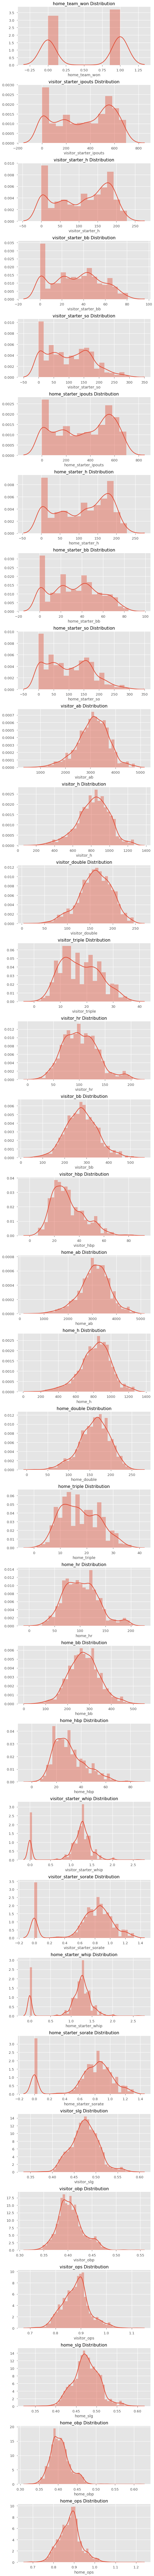

In [18]:
n = len(games_engineered.columns)
fig, ax_lst = plt.subplots(nrows=n, figsize=(8,n*4))
for ax, col in zip(ax_lst.flatten(), games_engineered.columns):
    sns.distplot(games_engineered[col], ax=ax)
    ax.set(title=f'{col} Distribution')
fig.tight_layout()

In [19]:
games_engineered.shape

(2428, 33)

## Pitching / hitting interaction columns.

In [20]:
starter_cols = [c for c in games_engineered.columns 
                if c.split('_')[1] == 'starter']
lineup_cols = [c for c in games_engineered.columns 
                if c.split('_')[1] != 'starter' 
               and c != 'home_team_won']

In [21]:
visitor_starter_cols = [c for c in starter_cols if c.startswith('visitor')]
home_starter_cols = [c for c in starter_cols if c.startswith('home')]

visitor_lineup_cols = [c for c in lineup_cols if c.startswith('visitor')]
home_lineup_cols = [c for c in lineup_cols if c.startswith('home')]

In [22]:
# Engineer columns ['{p_side}{p_stat}_{h_side}{h_stat}']
to_interact = [(visitor_starter_cols, home_lineup_cols),
               (home_starter_cols, visitor_lineup_cols)]

for starter, lineup in to_interact:
    for p_col in starter:
        p_split = p_col.split('_')
        p_side = p_split[0]
        p_stat = p_split[-1]
        for h_col in lineup:
            h_split = h_col.split('_')
            h_side = h_split[0]
            h_stat = h_split[-1]
            
            name = f'{p_side}_{p_stat}__{h_side}_{h_stat}'
            games_engineered[name] = games_engineered[p_col] * \
                                     games_engineered[h_col]
            
print(games_engineered.shape)
games_engineered.head()

(2428, 153)


,home_team_won,visitor_starter_ipouts,visitor_starter_h,visitor_starter_bb,visitor_starter_so,home_starter_ipouts,home_starter_h,home_starter_bb,home_starter_so,visitor_ab,visitor_h,visitor_double,visitor_triple,visitor_hr,visitor_bb,visitor_hbp,home_ab,home_h,home_double,home_triple,home_hr,home_bb,home_hbp,visitor_starter_whip,visitor_starter_sorate,home_starter_whip,home_starter_sorate,visitor_slg,visitor_obp,visitor_ops,home_slg,home_obp,home_ops,visitor_ipouts__home_ab,visitor_ipouts__home_h,visitor_ipouts__home_double,visitor_ipouts__home_triple,visitor_ipouts__home_hr,visitor_ipouts__home_bb,visitor_ipouts__home_hbp,visitor_ipouts__home_slg,visitor_ipouts__home_obp,visitor_ipouts__home_ops,visitor_h__home_ab,visitor_h__home_h,visitor_h__home_double,visitor_h__home_triple,visitor_h__home_hr,visitor_h__home_bb,visitor_h__home_hbp,visitor_h__home_slg,visitor_h__home_obp,visitor_h__home_ops,visitor_bb__home_ab,visitor_bb__home_h,visitor_bb__home_double,visitor_bb__home_triple,visitor_bb__home_hr,visitor_bb__home_bb,visitor_bb__home_hbp,visitor_bb__home_slg,visitor_bb__home_obp,visitor_bb__home_ops,visitor_so__home_ab,visitor_so__home_h,visitor_so__home_double,visitor_so__home_triple,visitor_so__home_hr,visitor_so__home_bb,visitor_so__home_hbp,visitor_so__home_slg,visitor_so__home_obp,visitor_so__home_ops,visitor_whip__home_ab,visitor_whip__home_h,visitor_whip__home_double,visitor_whip__home_triple,visitor_whip__home_hr,visitor_whip__home_bb,visitor_whip__home_hbp,visitor_whip__home_slg,visitor_whip__home_obp,visitor_whip__home_ops,visitor_sorate__home_ab,visitor_sorate__home_h,visitor_sorate__home_double,visitor_sorate__home_triple,visitor_sorate__home_hr,visitor_sorate__home_bb,visitor_sorate__home_hbp,visitor_sorate__home_slg,visitor_sorate__home_obp,visitor_sorate__home_ops,home_ipouts__visitor_ab,home_ipouts__visitor_h,home_ipouts__visitor_double,home_ipouts__visitor_triple,home_ipouts__visitor_hr,home_ipouts__visitor_bb,home_ipouts__visitor_hbp,home_ipouts__visitor_slg,home_ipouts__visitor_obp,home_ipouts__visitor_ops,home_h__visitor_ab,home_h__visitor_h,home_h__visitor_double,home_h__visitor_triple,home_h__visitor_hr,home_h__visitor_bb,home_h__visitor_hbp,home_h__visitor_slg,home_h__visitor_obp,home_h__visitor_ops,home_bb__visitor_ab,home_bb__visitor_h,home_bb__visitor_double,home_bb__visitor_triple,home_bb__visitor_hr,home_bb__visitor_bb,home_bb__visitor_hbp,home_bb__visitor_slg,home_bb__visitor_obp,home_bb__visitor_ops,home_so__visitor_ab,home_so__visitor_h,home_so__visitor_double,home_so__visitor_triple,home_so__visitor_hr,home_so__visitor_bb,home_so__visitor_hbp,home_so__visitor_slg,home_so__visitor_obp,home_so__visitor_ops,home_whip__visitor_ab,home_whip__visitor_h,home_whip__visitor_double,home_whip__visitor_triple,home_whip__visitor_hr,home_whip__visitor_bb,home_whip__visitor_hbp,home_whip__visitor_slg,home_whip__visitor_obp,home_whip__visitor_ops,home_sorate__visitor_ab,home_sorate__visitor_h,home_sorate__visitor_double,home_sorate__visitor_triple,home_sorate__visitor_hr,home_sorate__visitor_bb,home_sorate__visitor_hbp,home_sorate__visitor_slg,home_sorate__visitor_obp,home_sorate__visitor_ops
0,1,568.0,156.0,37.0,188.0,601.0,190.0,72.0,155.0,3738.0,998.0,219.0,22.0,151.0,348.0,46.0,4205.0,1156.0,228.0,26.0,117.0,296.0,62.0,1.019366,0.992958,1.307820,0.773710,0.512560,0.416268,0.928828,0.464518,0.393553,0.858071,2388440.0,656608.0,129504.0,14768.0,66456.0,168128.0,35216.0,263.846114,223.538342,487.384455,655980.0,180336.0,35568.0,4056.0,18252.0,46176.0,9672.0,72.464778,61.394333,133.859111,155585.0,42772.0,8436.0,962.0,4329.0,10952.0,2294.0,17.187159,14.561476,31.748635,790540.0,217328.0,42864.0,4888.0,21996.0,55648.0,11656.0,87.329348,73.988043,161.317390,4286.434859,1178.387324,232.415493,26.503521,119.265845,301.732394,63.200704,0.473514,0.401175,0.874689,4175.387324,1147.859155,226.394366,25.816901,116.176056,293.915493,61.563380,0.461247,0.390782,0.852028,2246538.0,599798.0,131619.0,13222.0,90751.0,209148.

# Class Imbalances?

In [23]:
games_engineered.head()

,home_team_won,visitor_starter_ipouts,visitor_starter_h,visitor_starter_bb,visitor_starter_so,home_starter_ipouts,home_starter_h,home_starter_bb,home_starter_so,visitor_ab,visitor_h,visitor_double,visitor_triple,visitor_hr,visitor_bb,visitor_hbp,home_ab,home_h,home_double,home_triple,home_hr,home_bb,home_hbp,visitor_starter_whip,visitor_starter_sorate,home_starter_whip,home_starter_sorate,visitor_slg,visitor_obp,visitor_ops,home_slg,home_obp,home_ops,visitor_ipouts__home_ab,visitor_ipouts__home_h,visitor_ipouts__home_double,visitor_ipouts__home_triple,visitor_ipouts__home_hr,visitor_ipouts__home_bb,visitor_ipouts__home_hbp,visitor_ipouts__home_slg,visitor_ipouts__home_obp,visitor_ipouts__home_ops,visitor_h__home_ab,visitor_h__home_h,visitor_h__home_double,visitor_h__home_triple,visitor_h__home_hr,visitor_h__home_bb,visitor_h__home_hbp,visitor_h__home_slg,visitor_h__home_obp,visitor_h__home_ops,visitor_bb__home_ab,visitor_bb__home_h,visitor_bb__home_double,visitor_bb__home_triple,visitor_bb__home_hr,visitor_bb__home_bb,visitor_bb__home_hbp,visitor_bb__home_slg,visitor_bb__home_obp,visitor_bb__home_ops,visitor_so__home_ab,visitor_so__home_h,visitor_so__home_double,visitor_so__home_triple,visitor_so__home_hr,visitor_so__home_bb,visitor_so__home_hbp,visitor_so__home_slg,visitor_so__home_obp,visitor_so__home_ops,visitor_whip__home_ab,visitor_whip__home_h,visitor_whip__home_double,visitor_whip__home_triple,visitor_whip__home_hr,visitor_whip__home_bb,visitor_whip__home_hbp,visitor_whip__home_slg,visitor_whip__home_obp,visitor_whip__home_ops,visitor_sorate__home_ab,visitor_sorate__home_h,visitor_sorate__home_double,visitor_sorate__home_triple,visitor_sorate__home_hr,visitor_sorate__home_bb,visitor_sorate__home_hbp,visitor_sorate__home_slg,visitor_sorate__home_obp,visitor_sorate__home_ops,home_ipouts__visitor_ab,home_ipouts__visitor_h,home_ipouts__visitor_double,home_ipouts__visitor_triple,home_ipouts__visitor_hr,home_ipouts__visitor_bb,home_ipouts__visitor_hbp,home_ipouts__visitor_slg,home_ipouts__visitor_obp,home_ipouts__visitor_ops,home_h__visitor_ab,home_h__visitor_h,home_h__visitor_double,home_h__visitor_triple,home_h__visitor_hr,home_h__visitor_bb,home_h__visitor_hbp,home_h__visitor_slg,home_h__visitor_obp,home_h__visitor_ops,home_bb__visitor_ab,home_bb__visitor_h,home_bb__visitor_double,home_bb__visitor_triple,home_bb__visitor_hr,home_bb__visitor_bb,home_bb__visitor_hbp,home_bb__visitor_slg,home_bb__visitor_obp,home_bb__visitor_ops,home_so__visitor_ab,home_so__visitor_h,home_so__visitor_double,home_so__visitor_triple,home_so__visitor_hr,home_so__visitor_bb,home_so__visitor_hbp,home_so__visitor_slg,home_so__visitor_obp,home_so__visitor_ops,home_whip__visitor_ab,home_whip__visitor_h,home_whip__visitor_double,home_whip__visitor_triple,home_whip__visitor_hr,home_whip__visitor_bb,home_whip__visitor_hbp,home_whip__visitor_slg,home_whip__visitor_obp,home_whip__visitor_ops,home_sorate__visitor_ab,home_sorate__visitor_h,home_sorate__visitor_double,home_sorate__visitor_triple,home_sorate__visitor_hr,home_sorate__visitor_bb,home_sorate__visitor_hbp,home_sorate__visitor_slg,home_sorate__visitor_obp,home_sorate__visitor_ops
0,1,568.0,156.0,37.0,188.0,601.0,190.0,72.0,155.0,3738.0,998.0,219.0,22.0,151.0,348.0,46.0,4205.0,1156.0,228.0,26.0,117.0,296.0,62.0,1.019366,0.992958,1.307820,0.773710,0.512560,0.416268,0.928828,0.464518,0.393553,0.858071,2388440.0,656608.0,129504.0,14768.0,66456.0,168128.0,35216.0,263.846114,223.538342,487.384455,655980.0,180336.0,35568.0,4056.0,18252.0,46176.0,9672.0,72.464778,61.394333,133.859111,155585.0,42772.0,8436.0,962.0,4329.0,10952.0,2294.0,17.187159,14.561476,31.748635,790540.0,217328.0,42864.0,4888.0,21996.0,55648.0,11656.0,87.329348,73.988043,161.317390,4286.434859,1178.387324,232.415493,26.503521,119.265845,301.732394,63.200704,0.473514,0.401175,0.874689,4175.387324,1147.859155,226.394366,25.816901,116.176056,293.915493,61.563380,0.461247,0.390782,0.852028,2246538.0,599798.0,131619.0,13222.0,90751.0,209148.

In [24]:
games_engineered['home_team_won'].value_counts(normalize=True)

1    0.530066
0    0.469934
Name: home_team_won, dtype: float64

# Initial Modeling

In [25]:
from stopwatch import *
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [26]:
def show_metrics(model, X_test, y_test, label='', return_report=False):
    """
    Print a Classification Report, a Confusion Matrix, and a ROC-Curve.
    -------------------------------------------------------------------
    
    Parameters:
    -----------
    model: pre-fit model (type: scikit-learn)
        The model from which the assessments will be shown.
    X_test: pandas DataFrame
        Test independent variable data.
    y_test: pandas DataFrame
        Test target data.
    label: str (default: '')
        An optional label for the header of the printout.
    return_report: bool (default: False)
        If set to True, the classification report dictionary will be returned.
        
    Returns:
    --------
    If return_report is passed as True, a dictionary of the 
    classification report will be returned.
    """
    y_pred = model.predict(X_test)
    
    label += ' Classification Report'
    label = label.strip()
    print(label)
    print(''.join(['*' for _ in label]))
    print(metrics.classification_report(y_test, y_pred))
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    metrics.plot_confusion_matrix(model, X_test, y_test,
                                  normalize='true', cmap='Blues', ax=ax1)
    ax1.set(title='Confusion Matrix')
    ax1.grid(False)
    
    metrics.plot_roc_curve(model, X_test, y_test, ax=ax2)
    ax2.set(title='Receiving Operator Characteristic (ROC)')
    ax2.plot([0,1], [0,1], ls=':', color='blue')
    fig.tight_layout()
    
    plt.show()
    if return_report:
        report = metrics.classification_report(y_test, y_pred, 
                                               output_dict=True)
        return report

### train_test_split

In [27]:
X = games_engineered.drop('home_team_won', axis=1).copy()
y = games_engineered['home_team_won'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=51,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1821, 152), (607, 152), (1821,), (607,))

In [28]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

1    0.529929
0    0.470071
Name: home_team_won, dtype: float64

1    0.530478
0    0.469522
Name: home_team_won, dtype: float64

## Iterate over all vanilla models.

In [29]:
def iterate_over_vanilla_models(X_train, X_test, y_train, y_test):
    models = [
        ('logreg', LogisticRegression),
        ('forest', RandomForestClassifier),
        ('knn', KNeighborsClassifier),
        ('svc', SVC),
        ('xgb', XGBClassifier)
    ]

    #Initialize the stopwatch.
    watch = Stopwatch()

    for name, model in models:
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            (name, model())
        ])
        pipe.fit(X_train, y_train)

        show_metrics(pipe, X_test, y_test, label=f'//{name}//')
        watch.lap(label=name)

    watch.stop()
    watch.display_laps(show_stop=False)
    

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


//logreg// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       285
           1       0.59      0.65      0.61       322

    accuracy                           0.57       607
   macro avg       0.57      0.57      0.56       607
weighted avg       0.57      0.57      0.57       607



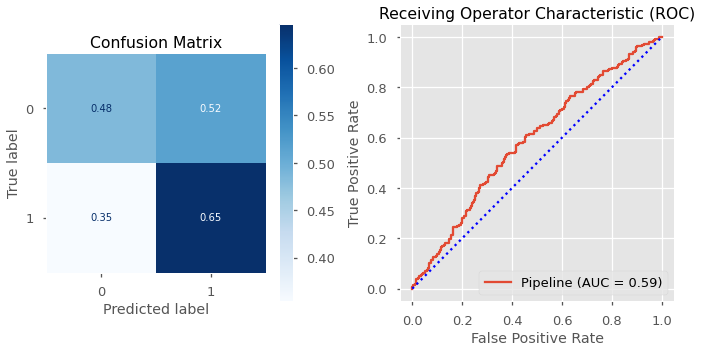

//forest// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       285
           1       0.54      0.57      0.56       322

    accuracy                           0.52       607
   macro avg       0.51      0.51      0.51       607
weighted avg       0.52      0.52      0.52       607



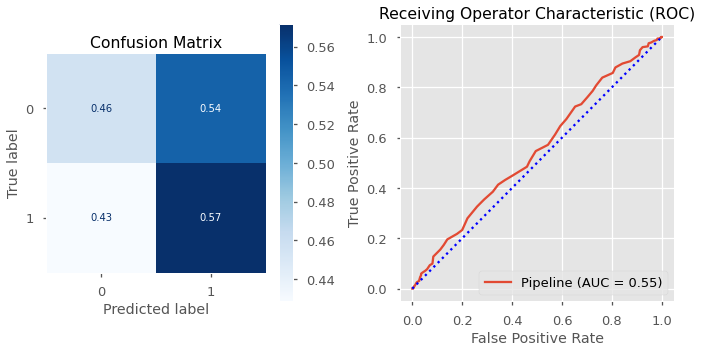

//knn// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.52      0.49      0.51       285
           1       0.57      0.60      0.58       322

    accuracy                           0.55       607
   macro avg       0.55      0.55      0.55       607
weighted avg       0.55      0.55      0.55       607



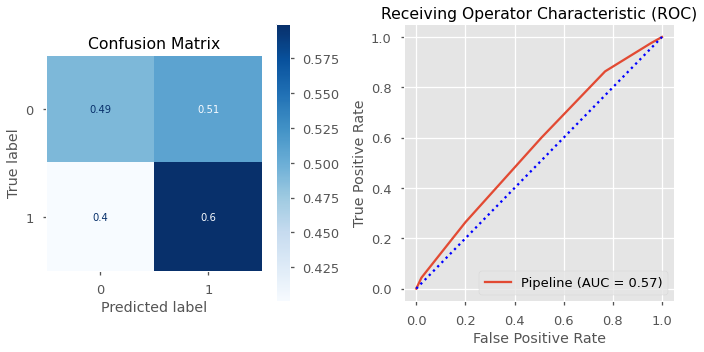

//svc// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       285
           1       0.58      0.63      0.61       322

    accuracy                           0.57       607
   macro avg       0.56      0.56      0.56       607
weighted avg       0.56      0.57      0.56       607



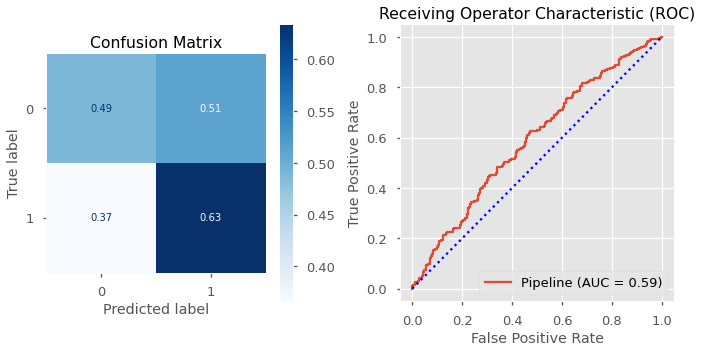

//xgb// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.48      0.47      0.47       285
           1       0.54      0.55      0.54       322

    accuracy                           0.51       607
   macro avg       0.51      0.51      0.51       607
weighted avg       0.51      0.51      0.51       607



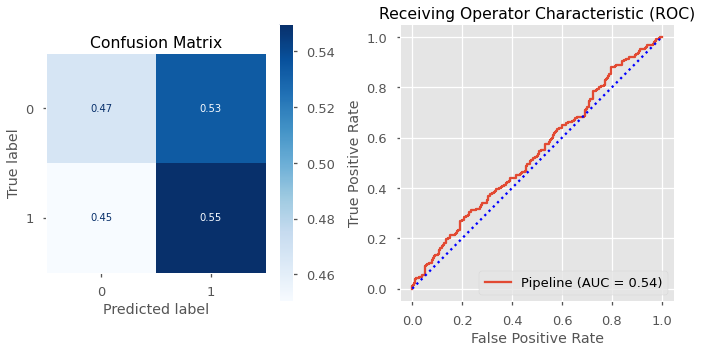

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-11 10:16:42.931119,0.000000
1,logreg,2020-09-11 10:16:43.438763,0.507644
2,forest,2020-09-11 10:16:45.111357,2.180238
3,knn,2020-09-11 10:16:46.353038,3.421919
4,svc,2020-09-11 10:16:48.034544,5.103425
5,xgb,2020-09-11 10:16:49.815782,6.884663


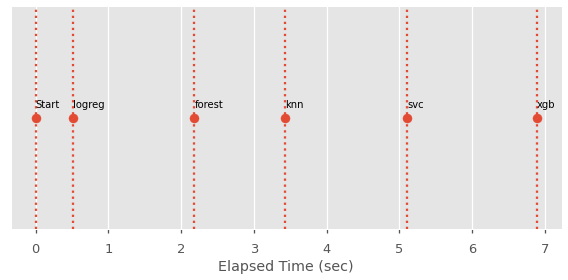

In [30]:
iterate_over_vanilla_models(X_train, X_test, y_train, y_test)

The vanilla `KNN` performs surprisingly well, especially for a model that hasn't been tuned. It doesn't seem to be over-guessing positives compared to the other models.

# Feature Selection

## Constant

In [31]:
# Any constant features?
(X_train.describe().loc['std'] == 0).any()

False

## Correlated

In [32]:
# Correration dataframe.
corr_df = X_train.corr().abs().stack().reset_index()
corr_df.columns = ['f1', 'f2', 'cc']
corr_df = corr_df[(corr_df['cc'] > 0.8) & (corr_df['cc'] < 1.0)]
display(corr_df.shape)
corr_df.head()

(2810, 3)

,f1,f2,cc
1,visitor_starter_ipouts,visitor_starter_h,0.972910
2,visitor_starter_ipouts,visitor_starter_bb,0.869609
3,visitor_starter_ipouts,visitor_starter_so,0.947181
32,visitor_starter_ipouts,visitor_ipouts__home_ab,0.941230
33,visitor_starter_ipouts,visitor_ipouts__home_h,0.934192


In [33]:
# Find groups of correlated features.
already_checked = []
grouped_corr_features = []

for feature in corr_df['f1'].unique():
    if feature in already_checked:
        continue
    all_corr = corr_df[corr_df['f1'] == feature]
    corr_with = list(all_corr['f2'].unique())
    already_checked += [feature] + corr_with
    
    grouped_corr_features.append(all_corr)

print(f'{len(grouped_corr_features)} groups of correlated features found.\n')
print('Example:')
for each in grouped_corr_features[:2]:
    display(each)

24 groups of correlated features found.

Example:


,f1,f2,cc
1,visitor_starter_ipouts,visitor_starter_h,0.972910
2,visitor_starter_ipouts,visitor_starter_bb,0.869609
3,visitor_starter_ipouts,visitor_starter_so,0.947181
32,visitor_starter_ipouts,visitor_ipouts__home_ab,0.941230
33,visitor_starter_ipouts,visitor_ipouts__home_h,0.934192
34,visitor_starter_ipouts,visitor_ipouts__home_double,0.932725
36,visitor_starter_ipouts,visitor_ipouts__home_hr,0.854206
37,visitor_starter_ipouts,visitor_ipouts__home_bb,0.910996
39,visitor_starter_ipouts,visitor_ipouts__home_slg,0.992307
40,visitor_starter_ipouts,visitor_ipouts__home_obp,0.993111


,f1,f2,cc
613,home_starter_ipouts,home_starter_h,0.973906
614,home_starter_ipouts,home_starter_bb,0.875231
615,home_starter_ipouts,home_starter_so,0.949267
700,home_starter_ipouts,home_ipouts__visitor_ab,0.941066
701,home_starter_ipouts,home_ipouts__visitor_h,0.934663
702,home_starter_ipouts,home_ipouts__visitor_double,0.931432
704,home_starter_ipouts,home_ipouts__visitor_hr,0.868266
705,home_starter_ipouts,home_ipouts__visitor_bb,0.909625
707,home_starter_ipouts,home_ipouts__visitor_slg,0.993058
708,home_starter_ipouts,home_ipouts__visitor_obp,0.993532


### Select features from correlated groups with RandomForestClassifier.

Example:


,feature,importance
14,visitor_h__home_hr,0.038387
28,visitor_so__home_hr,0.035924
6,visitor_ipouts__home_hr,0.035889
15,visitor_h__home_bb,0.034639
29,visitor_so__home_bb,0.033826
30,visitor_so__home_slg,0.032696
7,visitor_ipouts__home_bb,0.032482
31,visitor_so__home_obp,0.032036
12,visitor_h__home_h,0.031932
22,visitor_bb__home_slg,0.031592


,feature,importance
6,home_ipouts__visitor_hr,0.034429
7,home_ipouts__visitor_bb,0.033233
9,home_ipouts__visitor_obp,0.032927
32,home_so__visitor_obp,0.032112
4,home_ipouts__visitor_h,0.032100
20,home_bb__visitor_h,0.032079
14,home_h__visitor_hr,0.031737
22,home_bb__visitor_bb,0.031632
19,home_bb__visitor_ab,0.031504
12,home_h__visitor_h,0.031142


,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-11 10:16:50.756266,0.000000
1,Lap1,2020-09-11 10:16:51.447418,0.691152
2,Lap2,2020-09-11 10:16:52.075739,1.319473
3,Lap3,2020-09-11 10:16:52.450736,1.694470
4,Lap4,2020-09-11 10:16:52.848710,2.092444
5,Lap5,2020-09-11 10:16:53.276531,2.520265
6,Lap6,2020-09-11 10:16:53.768215,3.011949
7,Lap7,2020-09-11 10:16:54.333705,3.577439
8,Lap8,2020-09-11 10:16:54.738620,3.982354
9,Lap9,2020-09-11 10:16:55.055773,4.299507


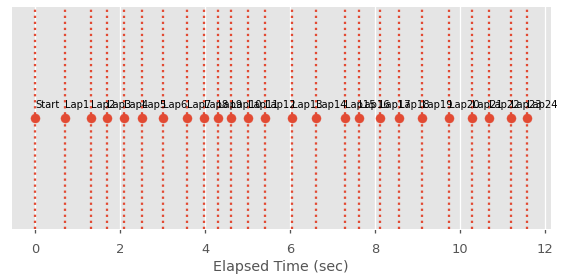

In [34]:
# Get lists of features that are correlated with each other.
features_in_groups = [list(grouped_corr_features[i]['f2'].unique()) + \
                      list(grouped_corr_features[i]['f1'].unique())
                      for i in range(len(grouped_corr_features))]

# Initiate list for feature_importance dataframes.
feature_importance_df_lst = []

watch = Stopwatch()

# Iterate over each group.
# Create a dataframe of feature importance.
for feature_lst in features_in_groups:
    forest = RandomForestClassifier(random_state=51)
    forest.fit(X_train[feature_lst], y_train)
    
    df = pd.concat(
        [pd.Series(feature_lst), 
         pd.Series(forest.feature_importances_)], 
        axis=1)
    df.columns = ['feature', 'importance']
    feature_importance_df_lst.append(df)
    watch.lap()
print('Example:')
for df in feature_importance_df_lst[:2]:
    display(df.sort_values('importance', ascending=False))
watch.display_laps()

In [35]:
# Get the top feature in each feature group.
features_to_keep = [df.iloc[df['importance'].argmax()]['feature'] 
                    for df in feature_importance_df_lst]
features_to_drop = list(set(already_checked) - set(features_to_keep))
features_to_drop

['home_bb__visitor_h',
 'visitor_ipouts__home_hr',
 'visitor_so__home_hr',
 'visitor_whip__home_triple',
 'home_bb__visitor_bb',
 'home_double',
 'visitor_bb__home_obp',
 'visitor_bb__home_hbp',
 'visitor_so__home_ab',
 'home_h__visitor_hr',
 'visitor_sorate__home_slg',
 'home_ipouts__visitor_double',
 'home_whip__visitor_h',
 'visitor_h__home_obp',
 'home_bb__visitor_obp',
 'home_whip__visitor_slg',
 'visitor_whip__home_hr',
 'visitor_so__home_obp',
 'home_ipouts__visitor_bb',
 'visitor_h__home_double',
 'home_h__visitor_ab',
 'visitor_so__home_bb',
 'visitor_h__home_ops',
 'home_whip__visitor_triple',
 'visitor_starter_ipouts',
 'visitor_starter_sorate',
 'visitor_sorate__home_bb',
 'home_h__visitor_bb',
 'visitor_so__home_double',
 'home_sorate__visitor_slg',
 'visitor_h__home_triple',
 'home_so__visitor_bb',
 'home_ipouts__visitor_slg',
 'home_sorate__visitor_double',
 'visitor_h',
 'visitor_bb__home_bb',
 'visitor_starter_h',
 'visitor_so__home_ops',
 'visitor_h__home_ab',
 'home_

### Drop correlated features.

In [36]:
X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

X_train.shape, X_test.shape

((1821, 29), (607, 29))

In [37]:
X_train.head()

,visitor_ab,visitor_triple,visitor_hr,visitor_bb,visitor_hbp,home_ab,home_triple,home_hr,home_bb,home_hbp,visitor_slg,visitor_obp,home_slg,home_ops,visitor_h__home_hr,visitor_h__home_bb,visitor_bb__home_triple,visitor_bb__home_hr,visitor_whip__home_double,visitor_whip__home_bb,visitor_whip__home_slg,visitor_sorate__home_double,visitor_sorate__home_triple,home_ipouts__visitor_hr,home_bb__visitor_hbp,home_so__visitor_triple,home_whip__visitor_ab,home_sorate__visitor_triple,home_sorate__visitor_bb
1321,3555.0,10.0,141.0,362.0,21.0,2460.0,14.0,68.0,161.0,38.0,0.499054,0.419294,0.443167,0.817337,6256.0,14812.0,518.0,2516.0,176.300000,230.766667,0.635206,87.466667,9.955556,16779.0,231.0,250.0,5915.042017,6.302521,228.151261
180,3783.0,13.0,180.0,434.0,42.0,2831.0,18.0,94.0,217.0,21.0,0.541276,0.451769,0.490551,0.890089,16262.0,37541.0,810.0,4230.0,197.720930,275.034884,0.621745,136.953488,15.802326,61200.0,966.0,1391.0,4572.979412,12.273529,409.747059
939,2939.0,15.0,105.0,237.0,26.0,2350.0,13.0,71.0,205.0,16.0,0.478326,0.391256,0.446219,0.826679,2414.0,6970.0,130.0,710.0,150.504673,252.897196,0.550476,116.299065,12.392523,10710.0,390.0,360.0,3544.088235,10.588235,167.294118
2122,3059.0,19.0,85.0,227.0,39.0,3606.0,24.0,115.0,282.0,49.0,0.460437,0.394200,0.469008,0.864427,19090.0,46812.0,1248.0,5980.0,231.813861,365.203960,0.607388,185.025743,24.807921,53210.0,1638.0,5206.0,3327.761981,24.948882,298.073482
67,2606.0,16.0,73.0,258.0,34.0,3236.0,10.0,68.0,270.0,25.0,0.469317,0.421348,0.429106,0.824889,11424.0,45360.0,630.0,4284.0,217.285714,347.142857,0.551707,173.076067,10.241187,43946.0,2482.0,2736.0,3402.518272,13.634551,219.857143


## Model check.

//logreg// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       285
           1       0.60      0.65      0.62       322

    accuracy                           0.58       607
   macro avg       0.58      0.58      0.58       607
weighted avg       0.58      0.58      0.58       607



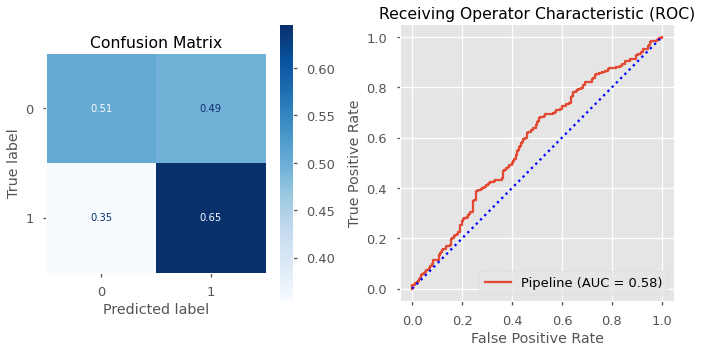

//forest// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       285
           1       0.56      0.57      0.56       322

    accuracy                           0.53       607
   macro avg       0.53      0.53      0.53       607
weighted avg       0.53      0.53      0.53       607



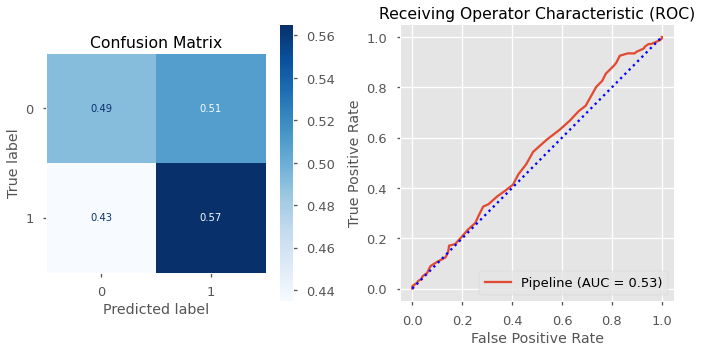

//knn// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       285
           1       0.55      0.56      0.56       322

    accuracy                           0.53       607
   macro avg       0.53      0.53      0.53       607
weighted avg       0.53      0.53      0.53       607



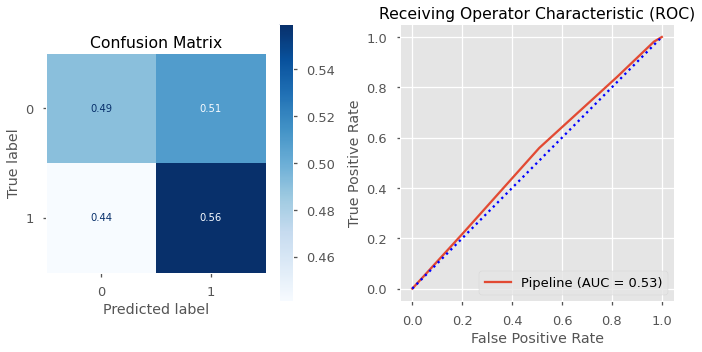

//svc// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       285
           1       0.56      0.57      0.56       322

    accuracy                           0.53       607
   macro avg       0.53      0.53      0.53       607
weighted avg       0.53      0.53      0.53       607



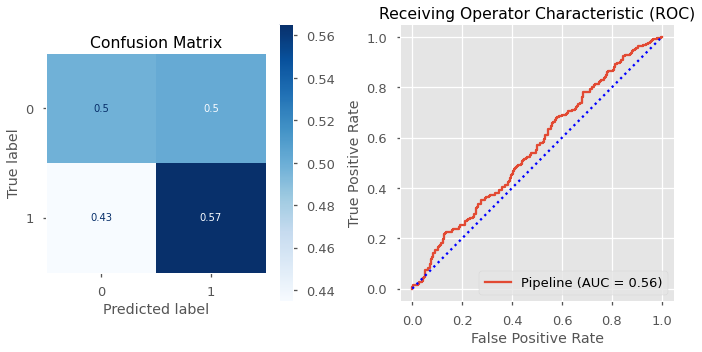

//xgb// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       285
           1       0.53      0.55      0.54       322

    accuracy                           0.51       607
   macro avg       0.50      0.50      0.50       607
weighted avg       0.50      0.51      0.50       607



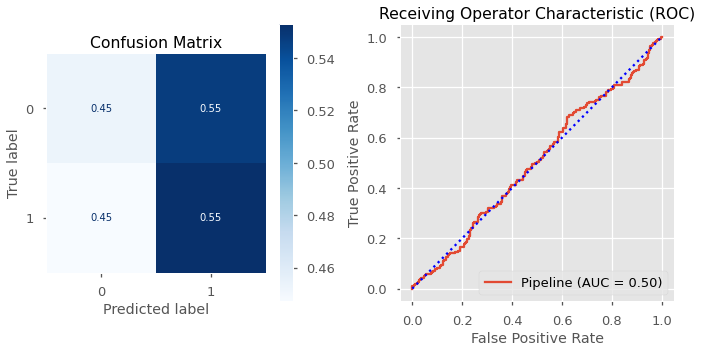

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-11 10:17:02.683790,0.000000
1,logreg,2020-09-11 10:17:03.139572,0.455782
2,forest,2020-09-11 10:17:04.463034,1.779244
3,knn,2020-09-11 10:17:05.072409,2.388619
4,svc,2020-09-11 10:17:05.787493,3.103703
5,xgb,2020-09-11 10:17:06.392873,3.709083


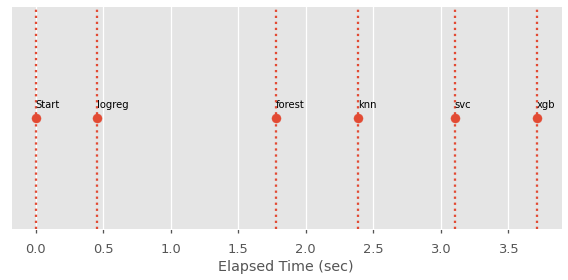

In [38]:
iterate_over_vanilla_models(X_train, X_test, y_train, y_test)

# Feature selection: RFC - Tree Importance

Number of features above 0.5 quantile: 14


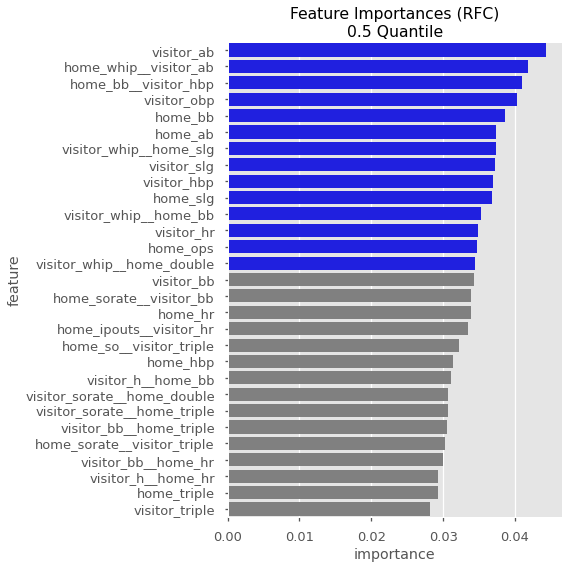

In [39]:
rfc = RandomForestClassifier(random_state=51)
rfc.fit(X_train, y_train)

rfc_importance = pd.DataFrame([rfc.feature_importances_, X_train.columns]).T
rfc_importance.columns = ['importance', 'feature']
rfc_importance.sort_values('importance', ascending=False, inplace=True)

q = .5
color_lst = ['blue' if x > rfc_importance['importance'].quantile(q) else 'grey' 
             for x in rfc_importance['importance']]

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x='importance', y='feature', orient='h', 
            data=rfc_importance, palette=color_lst, ax=ax)
ax.set(title=f'Feature Importances (RFC)\n{q} Quantile')

num_top = color_lst.count("blue")
print(f'Number of features above {q} quantile: {num_top}')
fig.tight_layout()

In [40]:
top_features = list(rfc_importance['feature'])[:num_top]
top_features

['visitor_ab',
 'home_whip__visitor_ab',
 'home_bb__visitor_hbp',
 'visitor_obp',
 'home_bb',
 'home_ab',
 'visitor_whip__home_slg',
 'visitor_slg',
 'visitor_hbp',
 'home_slg',
 'visitor_whip__home_bb',
 'visitor_hr',
 'home_ops',
 'visitor_whip__home_double']

## Model Check

//logreg// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.53      0.42      0.47       285
           1       0.57      0.67      0.61       322

    accuracy                           0.55       607
   macro avg       0.55      0.55      0.54       607
weighted avg       0.55      0.55      0.55       607



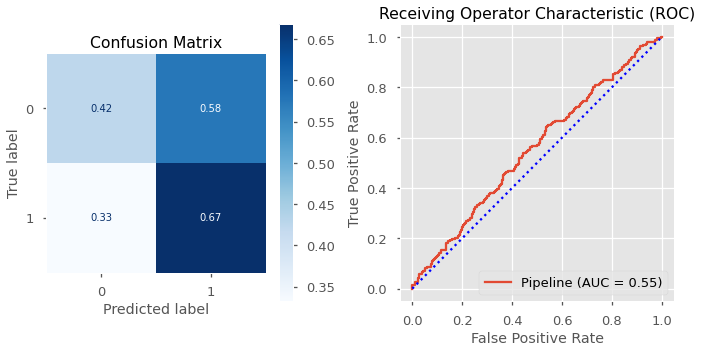

//forest// Classification Report
********************************
              precision    recall  f1-score   support

           0       0.48      0.47      0.47       285
           1       0.54      0.55      0.54       322

    accuracy                           0.51       607
   macro avg       0.51      0.51      0.51       607
weighted avg       0.51      0.51      0.51       607



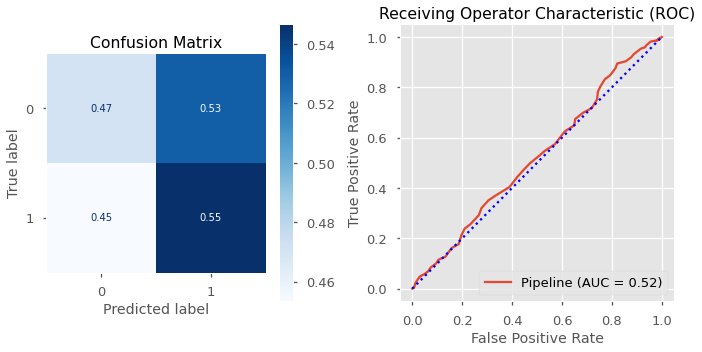

//knn// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       285
           1       0.56      0.55      0.55       322

    accuracy                           0.53       607
   macro avg       0.53      0.53      0.53       607
weighted avg       0.53      0.53      0.53       607



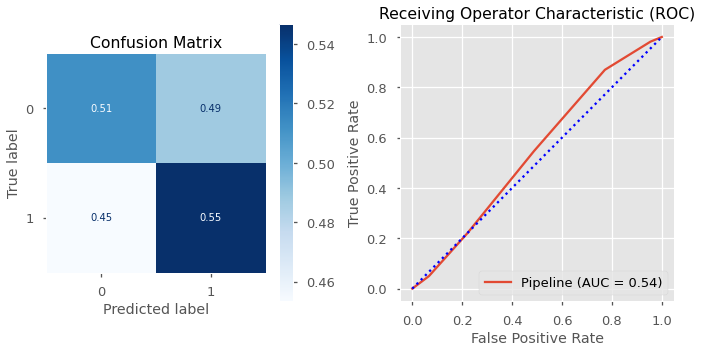

//svc// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       285
           1       0.57      0.63      0.60       322

    accuracy                           0.55       607
   macro avg       0.55      0.54      0.54       607
weighted avg       0.55      0.55      0.55       607



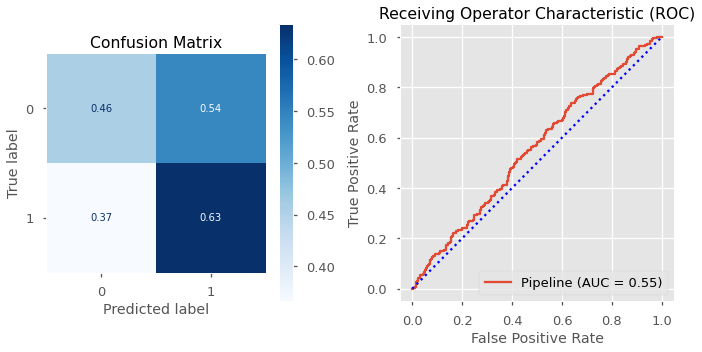

//xgb// Classification Report
*****************************
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       285
           1       0.54      0.58      0.56       322

    accuracy                           0.51       607
   macro avg       0.51      0.51      0.51       607
weighted avg       0.51      0.51      0.51       607



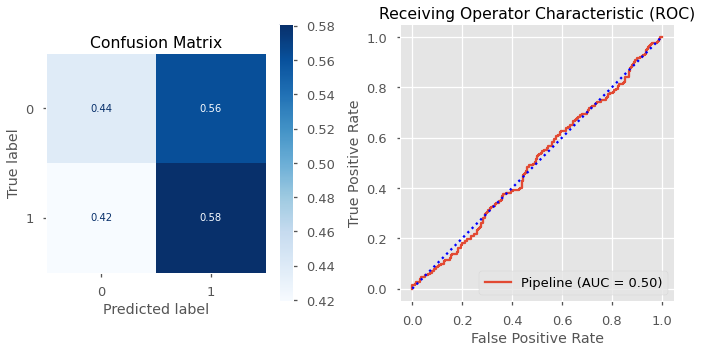

,Label,Timestamp,Elapsed Time (sec)
0,Start,2020-09-11 10:17:07.740271,0.000000
1,logreg,2020-09-11 10:17:08.156162,0.415891
2,forest,2020-09-11 10:17:08.987938,1.247667
3,knn,2020-09-11 10:17:09.460675,1.720404
4,svc,2020-09-11 10:17:10.142851,2.402580
5,xgb,2020-09-11 10:17:11.005543,3.265272


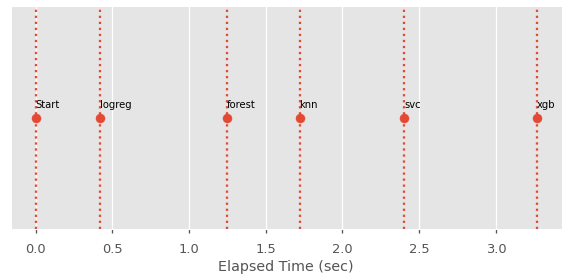

In [41]:
iterate_over_vanilla_models(X_train[top_features], X_test[top_features],
                            y_train, y_test)

There is a drop in performance in reducing the features.
I'm going to keep the non-correlated features and begin to tune the models.

# Model tuning and GridSearch

**Optimizing for Accuracy.**

### RUN_GRIDSEARCH

In [42]:
# Best as optimized for accuracy.
RUN_GRIDSEARCH = False

BEST_LOGREG = {'C': 1, 'fit_intercept': True, 'max_iter': 300}
BEST_RFC = {'criterion': 'gini',
            'max_depth': 4,
            'max_features': 'log2',
            'n_estimators': 200}
BEST_KNN = {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
BEST_SVC = {'C': 10, 'kernel': 'linear'}
BEST_XGB = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}

In [43]:
def gridsearch_model(model, 
                     model_name, 
                     params, 
                     X_train,
                     X_test,
                     y_train,
                     y_test,
                     scoring_metrics=['accuracy', 'f1', 
                                      'precision', 'recall', 
                                      'roc_auc']):
    """
    Fit and execute a GridSearch.
    Print metrics for each optimization.
    Return DataFrame with metrics.
    
    Parameters
    ----------
    model: An uninstantiated model (sklearn)
        
    model_name: str
        String to label the model-type throughout the process.
    params: dict
        Example: {param: [list, of, values]}
        Each key should point to a list of values to check.
    scoring_metrics: list of strings (default: ['accuracy', f1', 'precision', 
                                                'recall', 'roc_auc'])
        Metrics to try and optimize for.
    """
    try:
        model = model(random_state=51)
    except:
        model = model()
    
    # Set up params dict keys for the pipeline.
    if all([x.startswith(model_name) for x in params.keys()]):
        pass
    else:
        lst = list(params.keys())
        for k in lst:
            params[f'{model_name}__{k}'] = params.pop(k)
    
    # Initiate Pipeline with StandardScaler and model.
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model)
    ])
    
    # Prepare df.
    metrics_headers = ['model_label', 'best_params'] + scoring_metrics
    rows = []
    
    # Iterate over metrics to optimize for.
    watch = Stopwatch()
    for scoring in scoring_metrics:
        gridsearch = GridSearchCV(estimator=pipe, 
                            param_grid=params,
                            scoring=scoring,
                            cv=5)

        gridsearch.fit(X_train, y_train)

        best_pipe = gridsearch.best_estimator_
        best_pipe.fit(X_train, y_train)
        show_metrics(best_pipe, X_test, y_test, 
                     label=f'{model_name} (optimized for {scoring})')
        
        # Append the metrics to the `rows` list.
        y_pred = best_pipe.predict(X_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        rows.append([f'{model_name}-{scoring}', gridsearch.best_params_, 
                     acc, f1, precision, recall, roc_auc])

        watch.lap(label=scoring)
    watch.display_laps()

    return pd.DataFrame(rows, columns=metrics_headers)

In [44]:
def plot_comparisons(gridsearch_model_df):
    """
    Takes a dataframe returned from `gridsearch_model()`.
    Plots a grouped bar chart comparing metrics.
    """
    perf_df_t = gridsearch_model_df.drop('best_params', axis=1).T
    perf_df_t.columns = perf_df_t.iloc[0]
    perf_df_t = perf_df_t.iloc[1:]

    ax = perf_df_t.plot.barh(figsize=(10,6))
    fig = plt.gcf()

    ax.set(title='Metrics Comparison', 
           ylabel='Metric', xlabel='Score')
    ax.legend(loc='lower left')
    fig.tight_layout()
    
    plt.show()

## Logistic Regression

BEST logreg Classification Report
*********************************
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       285
           1       0.60      0.65      0.62       322

    accuracy                           0.58       607
   macro avg       0.58      0.58      0.58       607
weighted avg       0.58      0.58      0.58       607



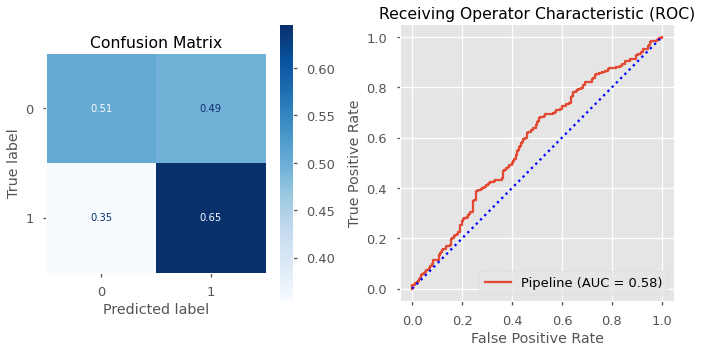

In [45]:
model = LogisticRegression
model_name = 'logreg'
params = {
    'C': [1, 10, 100, 1e3, 1e4, 1e5],
    'fit_intercept': [True, False],
    'max_iter': [300]
}

if RUN_GRIDSEARCH:
    logreg_df = gridsearch_model(model, model_name, params, 
                                 X_train, X_test, y_train, y_test)
    plot_comparisons(logreg_df)
else:
    logreg_pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model(**BEST_LOGREG, random_state=51))
    ])
    logreg_pipe.fit(X_train, y_train)
    show_metrics(logreg_pipe, X_test, y_test, 
                 label=f'BEST {model_name}')

In [46]:
if RUN_GRIDSEARCH:
    display(logreg_df[
        logreg_df['model_label'] == 'logreg-accuracy']['best_params'].values[0])

```python
BEST_LOGREG = {'logreg__C': 1, 'logreg__fit_intercept': True, 'logreg__max_iter': 300}
```

There is a significant difference in `recall` for the models optimized for recall and f1.
I'm going to try to keep the model optimized for accuracy for this problem.

## Random Forest Classifier

BEST rfc Classification Report
******************************
              precision    recall  f1-score   support

           0       0.51      0.38      0.44       285
           1       0.55      0.67      0.61       322

    accuracy                           0.54       607
   macro avg       0.53      0.53      0.52       607
weighted avg       0.53      0.54      0.53       607



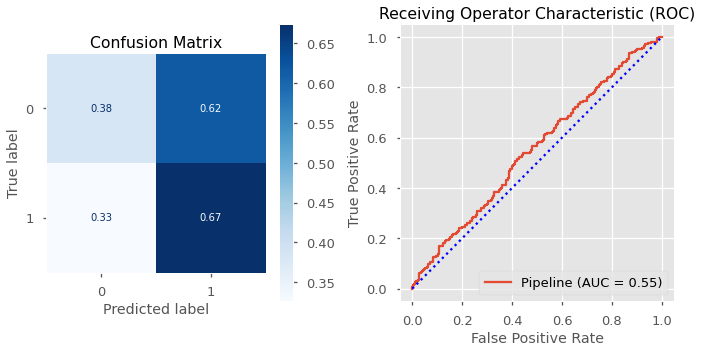

In [47]:
model = RandomForestClassifier
model_name = 'rfc'
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

if RUN_GRIDSEARCH:
    rfc_df = gridsearch_model(model, model_name, params, 
                              X_train, X_test, y_train, y_test)
    plot_comparisons(rfc_df)
else:
    rfc_pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model(**BEST_RFC, random_state=51))
    ])
    rfc_pipe.fit(X_train, y_train)
    show_metrics(rfc_pipe, X_test, y_test, 
                 label=f'BEST {model_name}')

The RFC performed much worse than Logistic Regression.

Optimizing for `roc_auc` seems to offer the worst results overall.

In [48]:
if RUN_GRIDSEARCH:
    display(rfc_df[
        rfc_df['model_label'] == 'rfc-accuracy']['best_params'].values[0])

```python
BEST_RFC = {'rfc__criterion': 'gini',
            'rfc__max_depth': 4,
            'rfc__max_features': 'log2',
            'rfc__n_estimators': 200}
```

## K-Nearest Neighbors Classifier

BEST knn Classification Report
******************************
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       285
           1       0.55      0.53      0.54       322

    accuracy                           0.52       607
   macro avg       0.52      0.52      0.52       607
weighted avg       0.52      0.52      0.52       607



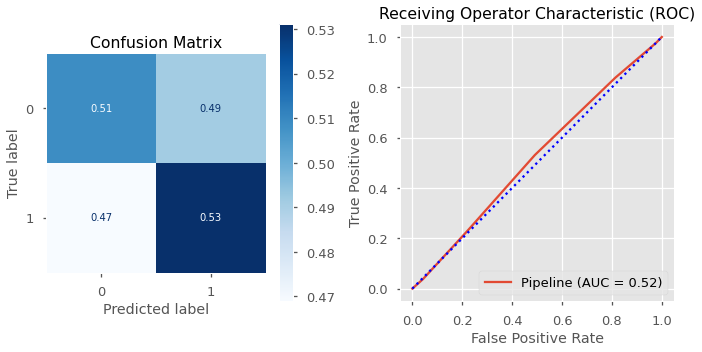

In [49]:
model = KNeighborsClassifier
model_name = 'knn'
params = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
}

if RUN_GRIDSEARCH:
    knn_df = gridsearch_model(model, model_name, params, 
                              X_train, X_test, y_train, y_test)
    plot_comparisons(knn_df)
else:
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model(**BEST_KNN))
    ])
    knn_pipe.fit(X_train, y_train)
    show_metrics(knn_pipe, X_test, y_test, 
                 label=f'BEST {model_name}')

In [50]:
if RUN_GRIDSEARCH:
    display(knn_df[
        knn_df['model_label'] == 'knn-accuracy']['best_params'].values[0])

```python
BEST_KNN = {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
```

## Support Vector Classifier

BEST svc Classification Report
******************************
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       285
           1       0.59      0.64      0.61       322

    accuracy                           0.57       607
   macro avg       0.57      0.57      0.57       607
weighted avg       0.57      0.57      0.57       607



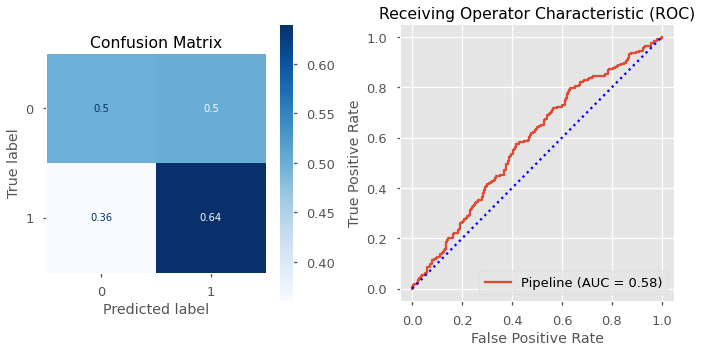

In [51]:
model = SVC
model_name = 'svc'
params = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'sigmoid']
}

if RUN_GRIDSEARCH:
    svc_df = gridsearch_model(model, model_name, params, 
                              X_train, X_test, y_train, y_test)
    plot_comparisons(svc_df)
else:
    svc_pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model(**BEST_SVC, random_state=51))
    ])
    svc_pipe.fit(X_train, y_train)
    show_metrics(svc_pipe, X_test, y_test, 
                 label=f'BEST {model_name}')

In [52]:
if RUN_GRIDSEARCH:
    display(svc_df[
        svc_df['model_label'] == 'svc-accuracy']['best_params'].values[0])

```python
BEST_SVC = {'svc__C': 10, 'svc__kernel': 'linear'}
```

## XGBoost Classifier

BEST xgb Classification Report
******************************
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       285
           1       0.57      0.60      0.58       322

    accuracy                           0.55       607
   macro avg       0.54      0.54      0.54       607
weighted avg       0.54      0.55      0.54       607



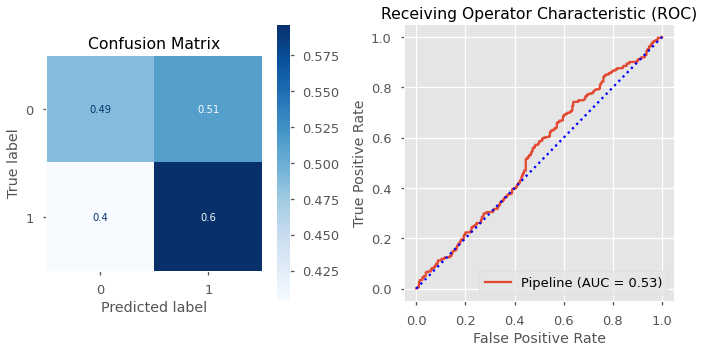

In [53]:
model = XGBClassifier
model_name = 'xgb'
params = {
    'max_depth': [3,5,7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    
}

if RUN_GRIDSEARCH:
    xgb_df = gridsearch_model(model, model_name, params, 
                              X_train, X_test, y_train, y_test)
    plot_comparisons(xgb_df)
else:
    xgb_pipe = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model(**BEST_XGB, random_state=51))
    ])
    xgb_pipe.fit(X_train, y_train)
    show_metrics(xgb_pipe, X_test, y_test, 
                 label=f'BEST {model_name}')

In [54]:
if RUN_GRIDSEARCH:
    display(xgb_df[
        xgb_df['model_label'] == 'xgb-accuracy']['best_params'].values[0])

```python
BEST_XGB = {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}
```

In [55]:
ALL_PIPES = [(logreg_pipe, 'logreg'), (rfc_pipe, 'rfc'), 
             (knn_pipe, 'knn'), (svc_pipe, 'svc'), (xgb_pipe, 'xgb')]

# All Reports

logreg Classification Report
****************************
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       285
           1       0.60      0.65      0.62       322

    accuracy                           0.58       607
   macro avg       0.58      0.58      0.58       607
weighted avg       0.58      0.58      0.58       607



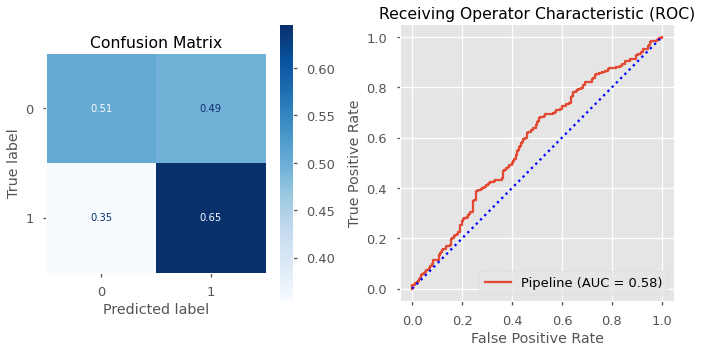

rfc Classification Report
*************************
              precision    recall  f1-score   support

           0       0.51      0.38      0.44       285
           1       0.55      0.67      0.61       322

    accuracy                           0.54       607
   macro avg       0.53      0.53      0.52       607
weighted avg       0.53      0.54      0.53       607



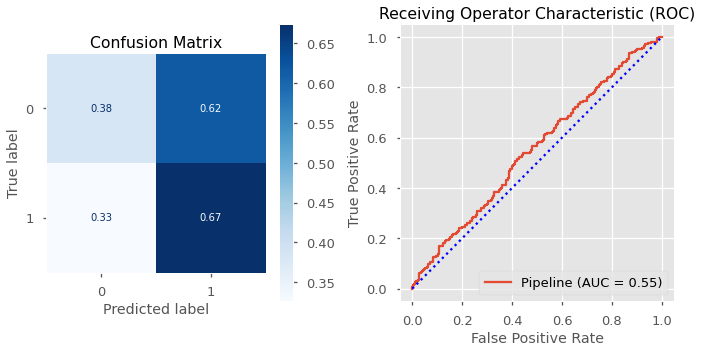

knn Classification Report
*************************
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       285
           1       0.55      0.53      0.54       322

    accuracy                           0.52       607
   macro avg       0.52      0.52      0.52       607
weighted avg       0.52      0.52      0.52       607



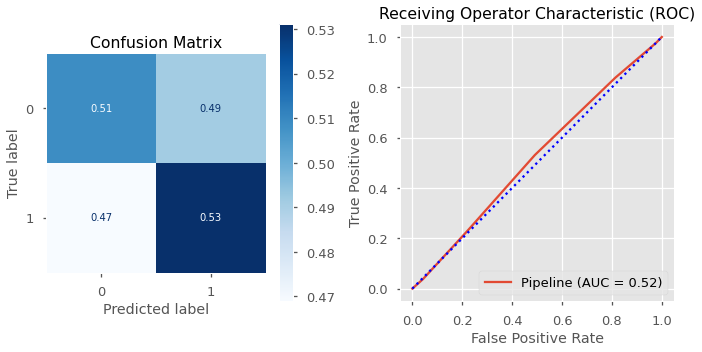

svc Classification Report
*************************
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       285
           1       0.59      0.64      0.61       322

    accuracy                           0.57       607
   macro avg       0.57      0.57      0.57       607
weighted avg       0.57      0.57      0.57       607



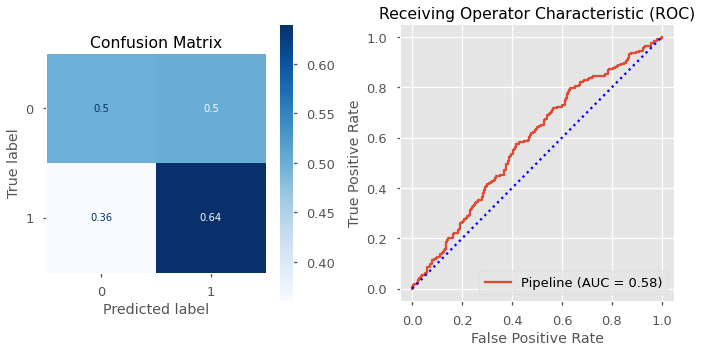

xgb Classification Report
*************************
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       285
           1       0.57      0.60      0.58       322

    accuracy                           0.55       607
   macro avg       0.54      0.54      0.54       607
weighted avg       0.54      0.55      0.54       607



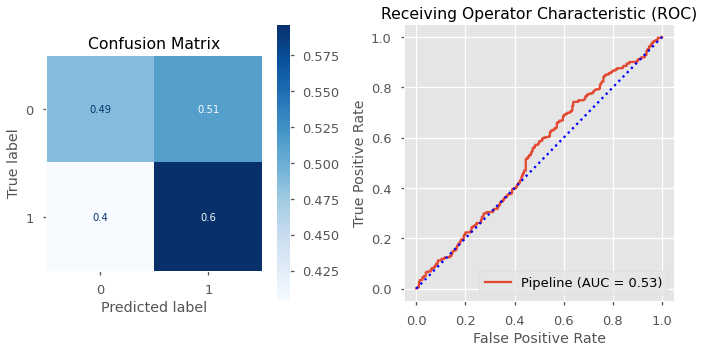

[({'0': {'precision': 0.5581395348837209,
    'recall': 0.5052631578947369,
    'f1-score': 0.5303867403314918,
    'support': 285},
   '1': {'precision': 0.5959885386819485,
    'recall': 0.6459627329192547,
    'f1-score': 0.6199701937406855,
    'support': 322},
   'accuracy': 0.5799011532125206,
   'macro avg': {'precision': 0.5770640367828347,
    'recall': 0.5756129454069958,
    'f1-score': 0.5751784670360887,
    'support': 607},
   'weighted avg': {'precision': 0.5782175896168829,
    'recall': 0.5799011532125206,
    'f1-score': 0.5779087699818384,
    'support': 607}},
  'logreg'),
 ({'0': {'precision': 0.5093457943925234,
    'recall': 0.3824561403508772,
    'f1-score': 0.43687374749499003,
    'support': 285},
   '1': {'precision': 0.5521628498727735,
    'recall': 0.6739130434782609,
    'f1-score': 0.6069930069930071,
    'support': 322},
   'accuracy': 0.5370675453047776,
   'macro avg': {'precision': 0.5307543221326485,
    'recall': 0.528184591914569,
    'f1-score':

In [56]:
all_reports = [(show_metrics(p, X_test, y_test, 
                             label=name, return_report=True), name)
               for (p, name) in ALL_PIPES]
all_reports

In [57]:
renamed_reports = []
for report, name in all_reports:
    r = pd.DataFrame(report)
    r.index = [f'{name}_{index}' for index in r.index]
    renamed_reports.append(r)

full_report = pd.concat(renamed_reports)
full_report

,0,1,accuracy,macro avg,weighted avg
logreg_precision,0.558140,0.595989,0.579901,0.577064,0.578218
logreg_recall,0.505263,0.645963,0.579901,0.575613,0.579901
logreg_f1-score,0.530387,0.619970,0.579901,0.575178,0.577909
logreg_support,285.000000,322.000000,0.579901,607.000000,607.000000
rfc_precision,0.509346,0.552163,0.537068,0.530754,0.532059
rfc_recall,0.382456,0.673913,0.537068,0.528185,0.537068
rfc_f1-score,0.436874,0.606993,0.537068,0.521933,0.527118
rfc_support,285.000000,322.000000,0.537068,607.000000,607.000000
knn_precision,0.489865,0.549839,0.520593,0.519852,0.521680
knn_recall,0.508772,0.531056,0.520593,0.519914,0.520593


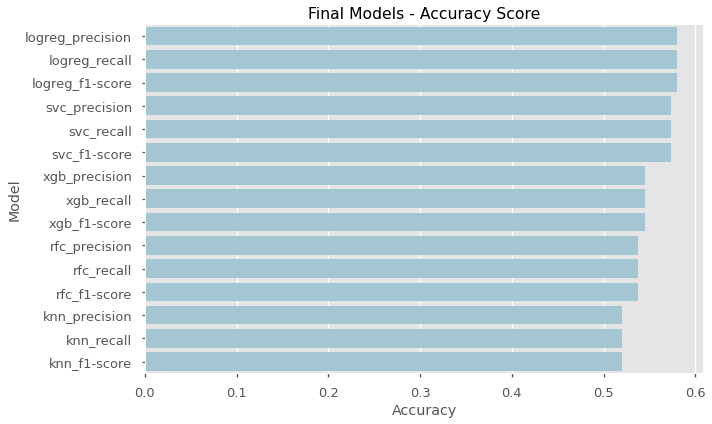

In [58]:
full_report = full_report.drop([c for c in full_report.index 
                                if c.endswith('support')])
full_report.sort_values('accuracy', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y=full_report.index, x='accuracy', 
            orient='h', data=full_report, color='#9cc9db')
ax.set(title='Final Models - Accuracy Score',
       xlabel='Accuracy', ylabel='Model')
fig.tight_layout()